# Análise sobre acumulação de Erro via sensor de Nav. Inercial

## Desenvolvimento do Filtro de Kalman Extendido (EKF)


Running Samples with 1 Iteration
Elapsed Time 34.2522 [ms]


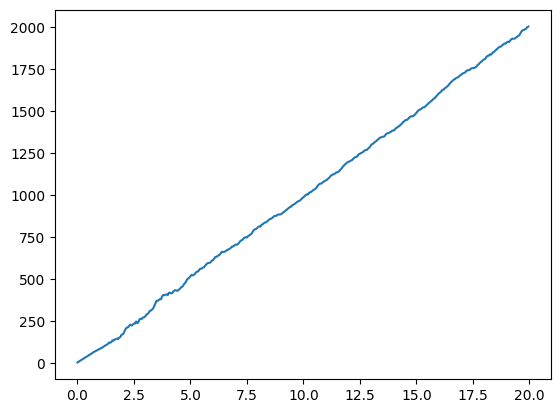

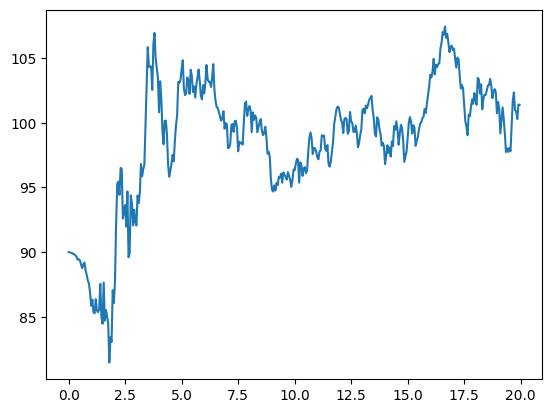

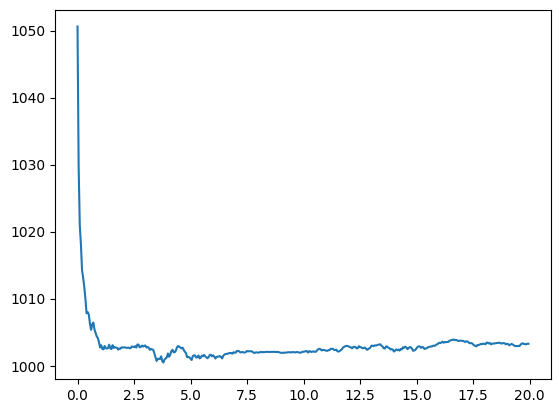

In [3]:
%run main.py


# KalmanTools Class Implementation (DPC++)

### CPU execution

In [8]:
!source /opt/intel/oneapi/setvars.sh > /dev/null && make Radar; ./Radar 1
!rm Radar 


make: 'Radar' is up to date.
Device:    	 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz
Number Iterations: 1
Average time execution(ms): 119


### GPU execution

In [9]:
!source /opt/intel/oneapi/setvars.sh > /dev/null && make Radar_gpu; ./Radar_gpu 1
!rm Radar_gpu


make: 'Radar_gpu' is up to date.
Device:    	 Intel(R) Iris(R) Xe Graphics [0x9a49]
Number Iterations: 1
Average time execution(ms): 2514
